In [1]:
import os
import pickle
import pandas as pd
import copy

# Plot function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image

Try to stitch multiple maps together. This works, but makes the GUI very slow to initialize and render. It's better to create a lower resolution map and scale it up.

In [2]:
replace_file = "../data/terrain_bitmaps/elevation_data_linear2.bmp"
map_rep  = Image.open(replace_file)
default_rep = np.array(map_rep)

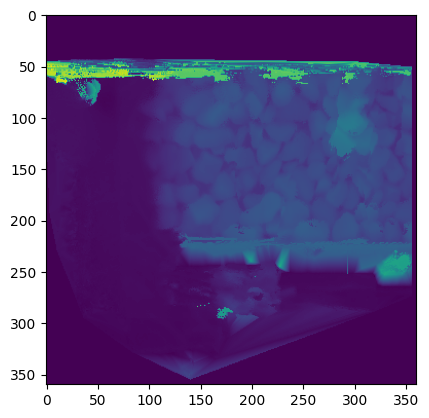

In [3]:
fig, ax = plt.subplots()
# ax.imshow(default_map, origin="lower")
ax.imshow(default_rep)

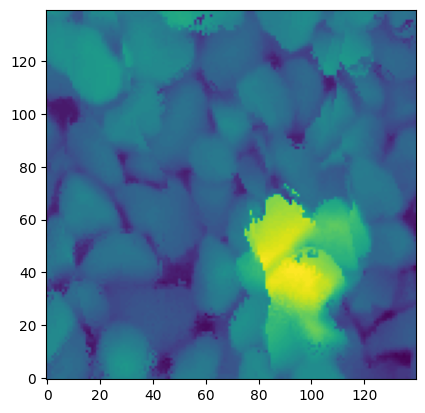

In [4]:
# Extract submaps and repeat
submap_rep = default_rep[69:209, 200:340]
fig, ax = plt.subplots()
ax.imshow(submap_rep, origin="lower")

In [5]:
example_file = "../data/terrain_bitmaps/elevation_data_linear.bmp"
map_img  = Image.open(example_file)
default_map = np.array(map_img)

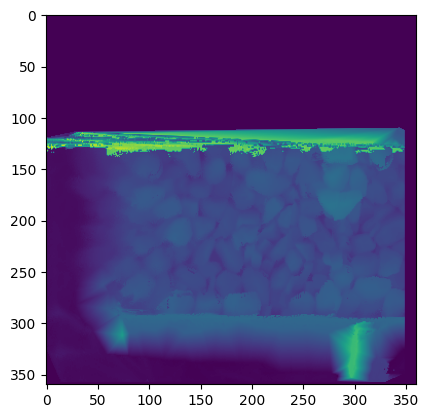

In [6]:
fig, ax = plt.subplots()
# ax.imshow(default_map, origin="lower")
ax.imshow(default_map)

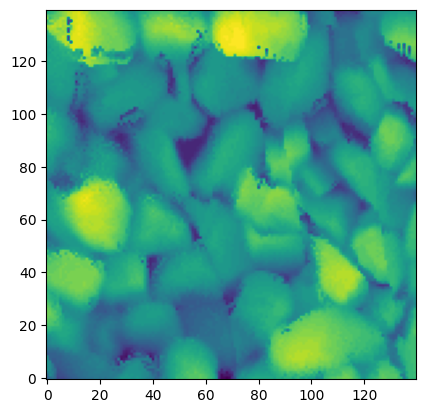

In [191]:
submap = default_map[150:290, 110:250] # size: 140
fig, ax = plt.subplots()
ax.imshow(submap, origin="lower")

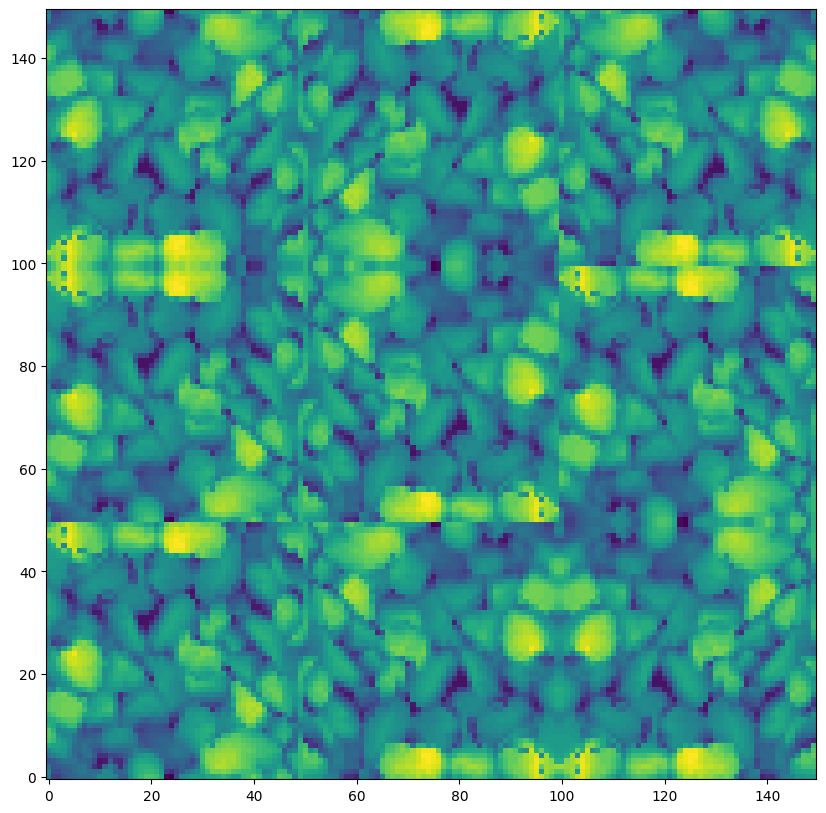

In [218]:
import cv2
# Now try to piece together terrain with random 90-deg change
def gen_random_map(submap_array, expand_ratio):
    num_rows, num_cols = expand_ratio
    submap_rows, submap_cols = submap_array.shape[:2]
    map_array = np.zeros((num_rows*submap_rows, num_cols*submap_cols), dtype=submap_array.dtype)

    img_obj = Image.fromarray(submap_array)
    for ri in range(num_rows):
        for ci in range(num_cols):
            modified_map = img_obj.copy()
            if np.random.rand()>0.5:
                # Flip left right
                modified_map = modified_map.transpose(Image.FLIP_LEFT_RIGHT)
            if np.random.rand()>0.5:
                # Flip up down
                modified_map = modified_map.transpose(Image.FLIP_TOP_BOTTOM)
            
            map_array[ri*submap_rows:(ri+1)*submap_rows, ci*submap_cols:(ci+1)*submap_cols] = np.array(modified_map)
    return map_array

coarse_submap = cv2.resize(submap, dsize=(50,50))
expand_ratio = (3, 3)
new_map = gen_random_map(coarse_submap, expand_ratio)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(new_map, origin="lower")

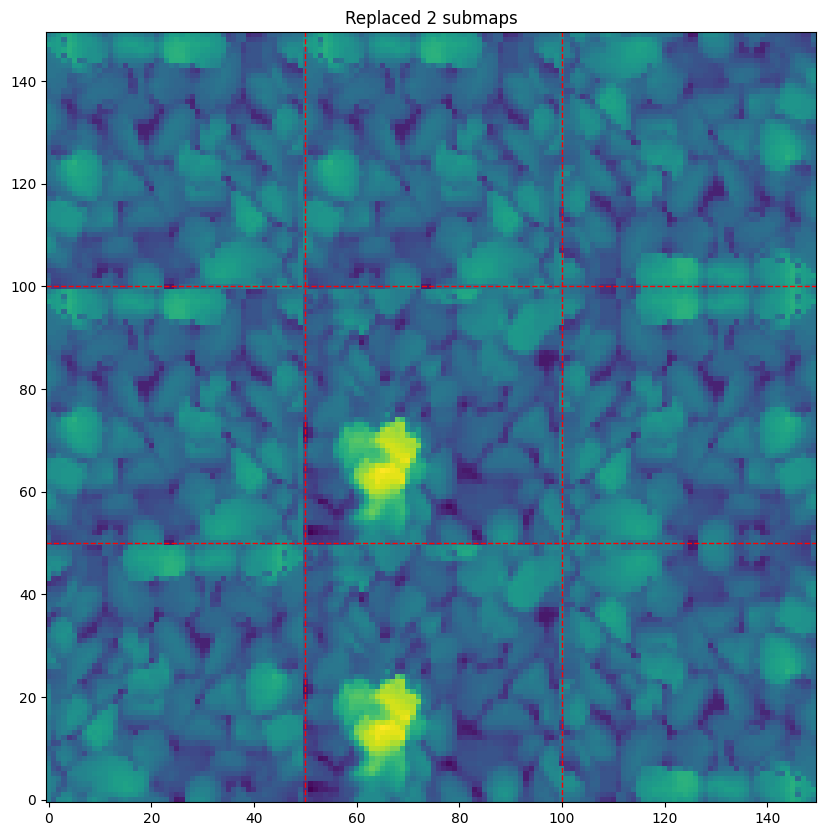

In [543]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def gen_random_map(submap_array, expand_ratio):
    num_rows, num_cols = expand_ratio
    submap_rows, submap_cols = submap_array.shape[:2]
    map_array = np.zeros((num_rows*submap_rows, num_cols*submap_cols), dtype=submap_array.dtype)
    img_obj = Image.fromarray(submap_array)
    for ri in range(num_rows):
        for ci in range(num_cols):
            modified_map = img_obj.copy()
            if np.random.rand() > 0.5:
                # Flip left right
                modified_map = modified_map.transpose(Image.FLIP_LEFT_RIGHT)
            if np.random.rand() > 0.5:
                # Flip up down
                modified_map = modified_map.transpose(Image.FLIP_TOP_BOTTOM)
            map_array[ri*submap_rows:(ri+1)*submap_rows, ci*submap_cols:(ci+1)*submap_cols] = np.array(modified_map)
    return map_array

def random_flip(image):
    """Randomly flip the image horizontally and/or vertically."""
    img = Image.fromarray(image)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if np.random.rand() > 0.5:
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return np.array(img)

# Generate the initial new_map
coarse_submap = cv2.resize(submap, dsize=(50,50))
expand_ratio = (3, 3)
new_map = gen_random_map(coarse_submap, expand_ratio)

# Calculate the dimensions of the submaps
submap_rows, submap_cols = 50, 50

# Resize submap_rep to match the size of the coarse_submap (50x50)
submap2_resized = Image.fromarray(submap_rep)
submap2_resized = submap2_resized.resize((submap_cols, submap_rows), Image.Resampling.LANCZOS)
submap2_array = np.array(submap2_resized)

# Get the shape of new_map
map_rows, map_cols = new_map.shape

# Calculate grid sizes
grid_rows, grid_cols = 3, 3
cell_height = map_rows // grid_rows
cell_width = map_cols // grid_cols

# Generate all possible grid positions
all_positions = [(r, c) for r in range(grid_rows) for c in range(grid_cols)]

# Randomly decide whether to replace one or two submaps
num_submaps = np.random.choice([1, 2])

# Randomly select grid positions
selected_positions = np.random.choice(len(all_positions), num_submaps, replace=False)

# Function to safely assign submap to new_map
def safe_assign(row_start, col_start, submap):
    row_end = min(map_rows, row_start + submap_rows)
    col_end = min(map_cols, col_start + submap_cols)
    
    row_range = row_end - row_start
    col_range = col_end - col_start
    
    new_map[row_start:row_end, col_start:col_end] = submap[:row_range, :col_range]

# Place submaps
for index in selected_positions:
    grid_row, grid_col = all_positions[index]
    
    # Calculate the center of the selected grid cell
    center_row = (grid_row * cell_height) + (cell_height // 2)
    center_col = (grid_col * cell_width) + (cell_width // 2)
    
    flipped_submap = random_flip(submap2_array)
    safe_assign(center_row - submap_rows // 2, center_col - submap_cols // 2, flipped_submap)

# Display the updated map with replaced submaps
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(new_map, origin='lower')

# Optionally, draw grid lines
for i in range(1, grid_rows):
    ax.axhline(y=i*cell_height, color='r', linestyle='--', linewidth=1)
for i in range(1, grid_cols):
    ax.axvline(x=i*cell_width, color='r', linestyle='--', linewidth=1)

plt.title(f"Replaced {num_submaps} submap{'s' if num_submaps > 1 else ''}")
plt.show()

In [544]:
new_map = Image.fromarray(new_map)
new_map.save("../data/terrain_bitmaps/level_5.bmp")

Analyze the slope and roughness from elevation map

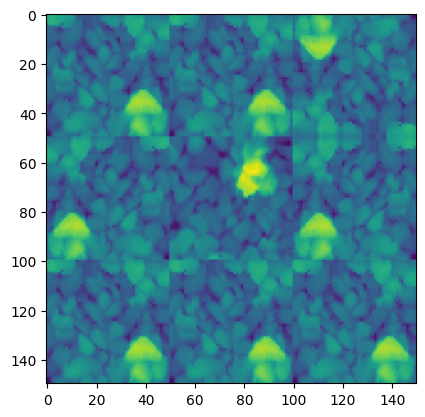

In [3]:
map_file = "../data/terrain_bitmaps/bumpy_coarse_3x3.bmp"
map_img  = Image.open(map_file)
map_img = np.array(map_img)
fig, ax = plt.subplots()
ax.imshow(map_img)

In [4]:
np.max(map_img), np.min(map_img)

(105, 32)